# Complete Guide to Ridge and Lasso Regression

## A Beginner-Friendly Introduction to Regularization Techniques

## Table of Contents

1. [Introduction to Regularization](#introduction)
2. [The Problem with Overfitting](#overfitting)
3. [Understanding Ridge Regression](#ridge)
4. [Understanding Lasso Regression](#lasso)
5. [Feature Standardization](#standardization)
6. [Practical Implementation](#implementation)
7. [Comparing Methods](#comparison)
8. [Hyperparameter Tuning](#tuning)
9. [Feature Selection with Lasso](#feature-selection)
10. [Summary and Best Practices](#summary)

## 1. Introduction to Regularization 

### What is Regularization?

**Regularization** is a technique used to prevent overfitting in machine learning models. Think of it as adding a "penalty" to complex models to make them simpler and more generalizable.

### Why Do We Need Regularization?

In traditional linear regression, we try to minimize the **Mean Squared Error (MSE)**:

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

However, this approach can lead to:
- **Overfitting**: Model performs well on training data but poorly on new data
- **High variance**: Small changes in training data cause large changes in the model
- **Multicollinearity issues**: When features are highly correlated

### The Solution: Penalized Regression

Instead of just minimizing the MSE, we add a **penalty term** that discourages large coefficients:

$$\text{Cost Function} = \text{MSE} + \text{Penalty Term}$$

## 2. The Problem with Overfitting 

Let's start by loading our libraries and data to see overfitting in action:

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the Ames housing dataset
df = pd.read_csv('ames.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1460, 81)

First few rows:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Get basic information about the dataset
print("Dataset Info:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nTarget variable (SalePrice) statistics:")
print(df['SalePrice'].describe())

Dataset Info:
Number of rows: 1460
Number of columns: 81

Target variable (SalePrice) statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


### Preparing the Data

Let's prepare our data by selecting numerical features and handling missing values:

In [4]:
# Select numerical features for simplicity
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('SalePrice')  # Remove target variable
numerical_features.remove('Id')  # Remove ID column

print(f"Selected {len(numerical_features)} numerical features:")
print(numerical_features[:10])  # Show first 10 features

Selected 36 numerical features:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']


In [5]:
# Prepare features and target
X = df[numerical_features].fillna(0)  # Simple imputation
y = df['SalePrice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1168, 36)
Test set shape: (292, 36)


### Demonstrating Overfitting with Polynomial Features

Let's create polynomial features to increase model complexity and demonstrate overfitting:

In [6]:
# Create polynomial features (degree 2) - this increases complexity significantly
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")
print(f"Feature expansion: {X_train_poly.shape[1] / X_train.shape[1]:.1f}x increase")

Original features: 36
Polynomial features: 666
Feature expansion: 18.5x increase


In [7]:
# Demonstrate overfitting with standard linear regression
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

# Make predictions
y_train_pred = lr.predict(X_train_poly)
y_test_pred = lr.predict(X_test_poly)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Standard Linear Regression with Polynomial Features:")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MSE: {train_mse:,.0f}")
print(f"Test MSE: {test_mse:,.0f}")
print(f"\n🚨 Overfitting detected! Test R² is much lower than training R²")

Standard Linear Regression with Polynomial Features:
Training R²: 0.9661
Test R²: 0.5529
Training MSE: 202,154,271
Test MSE: 3,429,023,029

🚨 Overfitting detected! Test R² is much lower than training R²


## 3. Understanding Ridge Regression 

### What is Ridge Regression?

**Ridge Regression** (also called **L2 regularization**) adds a penalty term that is proportional to the **sum of squares** of the coefficients.

### Mathematical Formula

$$\text{Cost Function}_{Ridge} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p}\beta_j^2$$

Where:
- The first term is the regular MSE (mean squared error)
- The second term is the **L2 penalty**: $\alpha \sum_{j=1}^{p}\beta_j^2$
- $\alpha$ (alpha) is the **regularization parameter** that controls the strength of regularization
- $\beta_j$ are the model coefficients

### How Ridge Works

1. **Shrinks coefficients**: Large coefficients are penalized more heavily
2. **Reduces overfitting**: By limiting coefficient sizes
3. **Handles multicollinearity**: When features are highly correlated
4. **Never sets coefficients to zero**: Unlike Lasso, Ridge only shrinks coefficients toward zero

### The Alpha Parameter

- **α = 0**: No regularization (same as linear regression)
- **Small α**: Light regularization
- **Large α**: Strong regularization (coefficients approach zero)

In [8]:
# Standardize features (important for regularization!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

print("✅ Features standardized for regularization")

✅ Features standardized for regularization


In [9]:
# Test different alpha values for Ridge regression
alphas = [0.1, 1, 10, 100, 1000]
ridge_results = []

for alpha in alphas:
    # Fit Ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = ridge.predict(X_train_scaled)
    y_test_pred = ridge.predict(X_test_scaled)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    ridge_results.append({
        'alpha': alpha,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'non_zero_coefs': np.sum(np.abs(ridge.coef_) > 1e-5)
    })

# Display results
ridge_df = pd.DataFrame(ridge_results)
print("Ridge Regression Results:")
print(ridge_df)

Ridge Regression Results:
    alpha  train_r2   test_r2  non_zero_coefs
0     0.1  0.961502  0.792400             661
1     1.0  0.958675  0.817305             661
2    10.0  0.949690  0.854731             661
3   100.0  0.929464  0.874882             661
4  1000.0  0.888560  0.859540             661


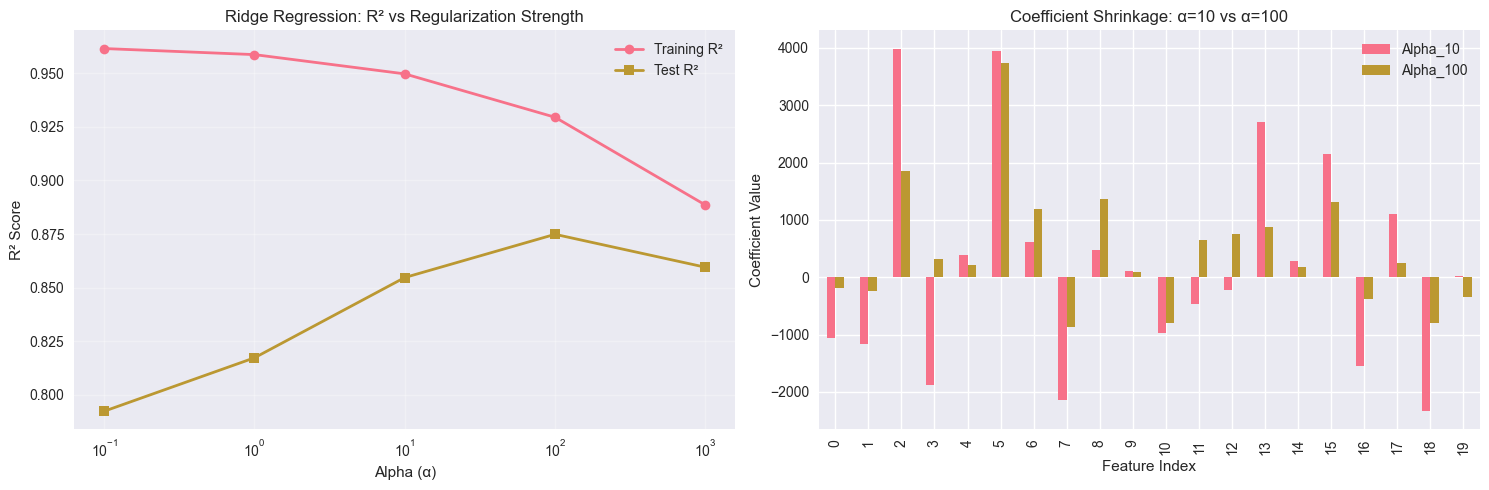

In [10]:
# Visualize Ridge regression performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot R² scores
ax1.plot(ridge_df['alpha'], ridge_df['train_r2'], 'o-', label='Training R²', linewidth=2)
ax1.plot(ridge_df['alpha'], ridge_df['test_r2'], 's-', label='Test R²', linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (α)')
ax1.set_ylabel('R² Score')
ax1.set_title('Ridge Regression: R² vs Regularization Strength')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Show coefficient shrinkage
ridge_alpha_10 = Ridge(alpha=10)
ridge_alpha_10.fit(X_train_scaled, y_train)

ridge_alpha_100 = Ridge(alpha=100)
ridge_alpha_100.fit(X_train_scaled, y_train)

coef_comparison = pd.DataFrame({
    'Alpha_10': ridge_alpha_10.coef_[:20],  # First 20 coefficients
    'Alpha_100': ridge_alpha_100.coef_[:20]
})

coef_comparison.plot(kind='bar', ax=ax2)
ax2.set_title('Coefficient Shrinkage: α=10 vs α=100')
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Coefficient Value')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Understanding Lasso Regression

### What is Lasso Regression?

**Lasso Regression** (Least Absolute Shrinkage and Selection Operator, also called **L1 regularization**) adds a penalty term that is proportional to the **sum of absolute values** of the coefficients.

### Mathematical Formula

$$\text{Cost Function}_{Lasso} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p}|\beta_j|$$

Where:
- The first term is the regular MSE
- The second term is the **L1 penalty**: $\alpha \sum_{j=1}^{p}|\beta_j|$
- $\alpha$ controls the regularization strength
- $|\beta_j|$ represents the absolute value of coefficients

### How Lasso Works

1. **Shrinks coefficients**: Like Ridge, but using absolute values
2. **Feature selection**: Can set coefficients exactly to zero
3. **Sparse models**: Automatically selects the most important features
4. **Interpretability**: Results in simpler, more interpretable models

### Key Difference from Ridge

- **Ridge**: Shrinks coefficients toward zero but never exactly zero
- **Lasso**: Can set coefficients exactly to zero, effectively removing features

In [11]:
# Test different alpha values for Lasso regression
alphas = [0.1, 1, 10, 100, 1000]
lasso_results = []

for alpha in alphas:
    # Fit Lasso regression
    lasso = Lasso(alpha=alpha, max_iter=1000)
    lasso.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = lasso.predict(X_train_scaled)
    y_test_pred = lasso.predict(X_test_scaled)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Count non-zero coefficients
    non_zero_coefs = np.sum(np.abs(lasso.coef_) > 1e-5)
    zero_coefs = np.sum(np.abs(lasso.coef_) <= 1e-5)
    
    lasso_results.append({
        'alpha': alpha,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'non_zero_coefs': non_zero_coefs,
        'zero_coefs': zero_coefs
    })

# Display results
lasso_df = pd.DataFrame(lasso_results)
print("Lasso Regression Results:")
print(lasso_df)

Lasso Regression Results:
    alpha  train_r2   test_r2  non_zero_coefs  zero_coefs
0     0.1  0.958093  0.792030             661           5
1     1.0  0.958051  0.796833             646          20
2    10.0  0.956975  0.821070             501         165
3   100.0  0.939730  0.876687             238         428
4  1000.0  0.892098  0.880576              59         607


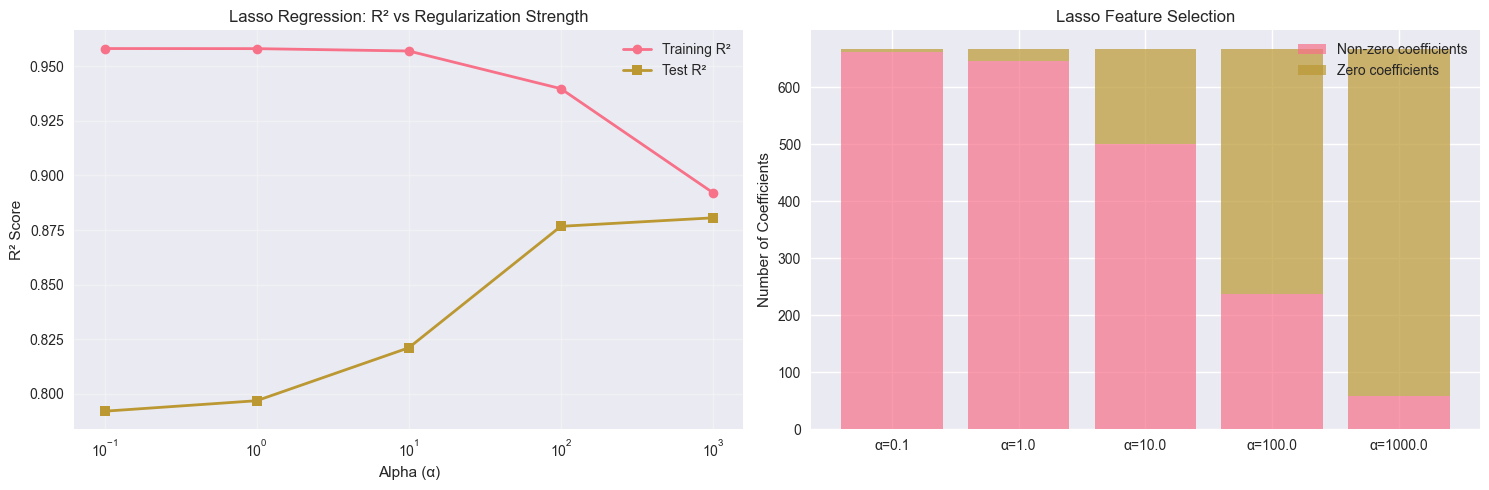


🎯 Key Insight: As alpha increases, Lasso sets more coefficients to zero!


In [12]:
# Visualize Lasso regression performance and feature selection
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot R² scores
ax1.plot(lasso_df['alpha'], lasso_df['train_r2'], 'o-', label='Training R²', linewidth=2)
ax1.plot(lasso_df['alpha'], lasso_df['test_r2'], 's-', label='Test R²', linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (α)')
ax1.set_ylabel('R² Score')
ax1.set_title('Lasso Regression: R² vs Regularization Strength')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot feature selection
ax2.bar(range(len(lasso_df)), lasso_df['non_zero_coefs'], alpha=0.7, label='Non-zero coefficients')
ax2.bar(range(len(lasso_df)), lasso_df['zero_coefs'], 
        bottom=lasso_df['non_zero_coefs'], alpha=0.7, label='Zero coefficients')
ax2.set_xticks(range(len(lasso_df)))
ax2.set_xticklabels([f'α={a}' for a in lasso_df['alpha']])
ax2.set_ylabel('Number of Coefficients')
ax2.set_title('Lasso Feature Selection')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n🎯 Key Insight: As alpha increases, Lasso sets more coefficients to zero!")

## 5. Feature Standardization 
### Why Standardization is Critical

**Before applying Ridge or Lasso regression, you MUST standardize your features!**

Here's why:

1. **Different scales**: Features often have different units and scales
2. **Unfair penalization**: Regularization penalizes based on coefficient magnitude
3. **Bias toward small-scale features**: Features with larger scales get penalized more

### Example: Why Standardization Matters

In [13]:
# Create a simple example to demonstrate the importance of standardization
# Let's look at some features with very different scales

feature_stats = X_train[['LotArea', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']].describe()
print("Feature Statistics (before standardization):")
print(feature_stats.round(2))
print("\n📊 Notice the huge differences in scale!")

Feature Statistics (before standardization):
         LotArea  YearBuilt  TotalBsmtSF  GrLivArea
count    1168.00    1168.00      1168.00    1168.00
mean    10689.64    1970.97      1061.77    1527.40
std     10759.37      30.68       440.68     524.43
min      1300.00    1872.00         0.00     334.00
25%      7587.25    1953.00       796.00    1145.75
50%      9600.00    1972.00       997.50    1473.00
75%     11700.00    2001.00      1299.25    1792.00
max    215245.00    2010.00      6110.00    5642.00

📊 Notice the huge differences in scale!


In [14]:
# Compare Ridge regression with and without standardization
# Use a subset of features for clarity
subset_features = ['LotArea', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']
X_subset = X_train[subset_features]
X_test_subset = X_test[subset_features]

# Without standardization
ridge_no_std = Ridge(alpha=10)
ridge_no_std.fit(X_subset, y_train)
coef_no_std = ridge_no_std.coef_

# With standardization
scaler_subset = StandardScaler()
X_subset_scaled = scaler_subset.fit_transform(X_subset)
X_test_subset_scaled = scaler_subset.transform(X_test_subset)

ridge_std = Ridge(alpha=10)
ridge_std.fit(X_subset_scaled, y_train)
coef_std = ridge_std.coef_

# Compare coefficients
comparison = pd.DataFrame({
    'Feature': subset_features,
    'No Standardization': coef_no_std,
    'With Standardization': coef_std,
    'Feature Scale (std)': X_subset.std()
})

print("Coefficient Comparison:")
print(comparison.round(4))
print("\n⚠️ Without standardization, features with larger scales get unfairly small coefficients!")

Coefficient Comparison:
                 Feature  No Standardization  With Standardization  \
LotArea          LotArea              0.4810             5201.7455   
YearBuilt      YearBuilt            866.2642            26360.6239   
TotalBsmtSF  TotalBsmtSF             36.6614            16242.9047   
GrLivArea      GrLivArea             77.3040            40163.8122   

             Feature Scale (std)  
LotArea               10759.3662  
YearBuilt                30.6755  
TotalBsmtSF             440.6763  
GrLivArea               524.4327  

⚠️ Without standardization, features with larger scales get unfairly small coefficients!


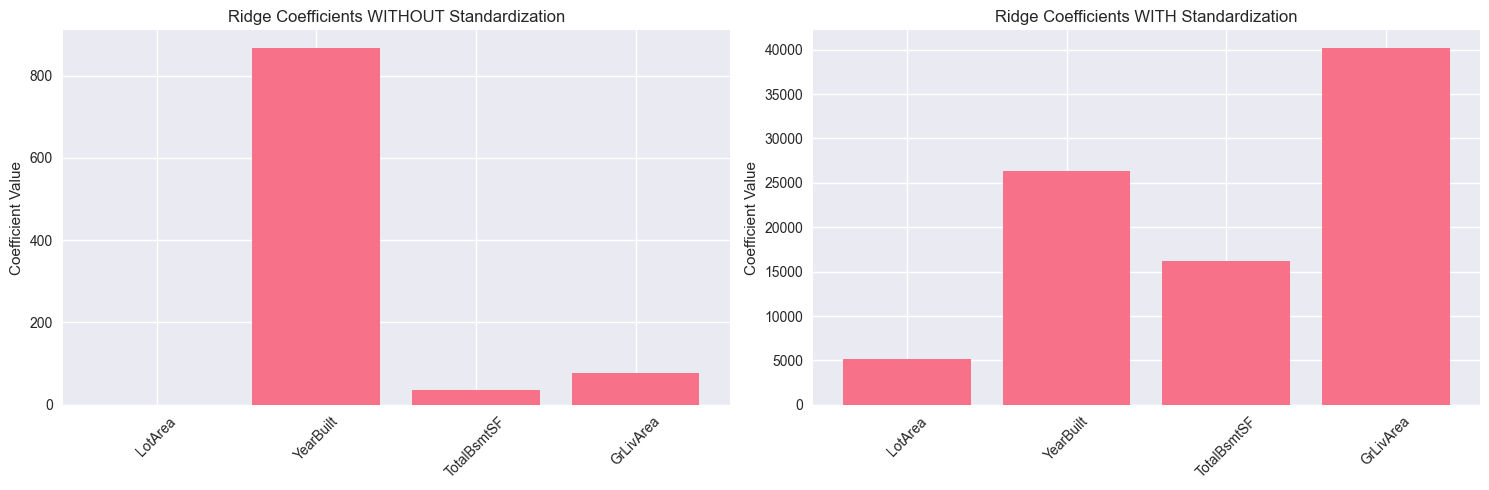

In [15]:
# Visualize the impact of standardization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot coefficients without standardization
ax1.bar(range(len(subset_features)), coef_no_std)
ax1.set_xticks(range(len(subset_features)))
ax1.set_xticklabels(subset_features, rotation=45)
ax1.set_title('Ridge Coefficients WITHOUT Standardization')
ax1.set_ylabel('Coefficient Value')

# Plot coefficients with standardization
ax2.bar(range(len(subset_features)), coef_std)
ax2.set_xticks(range(len(subset_features)))
ax2.set_xticklabels(subset_features, rotation=45)
ax2.set_title('Ridge Coefficients WITH Standardization')
ax2.set_ylabel('Coefficient Value')

plt.tight_layout()
plt.show()

## 6. Practical Implementation 

Now let's implement Ridge and Lasso regression properly with our housing dataset:

In [16]:
# Step 1: Prepare the data properly
def prepare_data(X_train, X_test, y_train, y_test):
    """
    Prepare data for regularized regression:
    1. Fill missing values
    2. Standardize features
    """
    # Handle missing values (simple imputation)
    X_train_clean = X_train.fillna(X_train.mean())
    X_test_clean = X_test.fillna(X_train.mean())  # Use training mean for test set
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    
    return X_train_scaled, X_test_scaled, scaler

# Prepare our data
X_train_final, X_test_final, scaler = prepare_data(X_train, X_test, y_train, y_test)
print("✅ Data prepared successfully!")
print(f"Training set shape: {X_train_final.shape}")
print(f"Test set shape: {X_test_final.shape}")

✅ Data prepared successfully!
Training set shape: (1168, 36)
Test set shape: (292, 36)


In [17]:
# Step 2: Build and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate a regression model and return metrics
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Count non-zero coefficients (for regularized models)
    if hasattr(model, 'coef_'):
        non_zero_coefs = np.sum(np.abs(model.coef_) > 1e-5)
    else:
        non_zero_coefs = 'N/A'
    
    return {
        'Model': model_name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Non-zero Coefficients': non_zero_coefs,
        'Overfitting': train_r2 - test_r2
    }

# Build and evaluate different models
models_to_test = [
    (LinearRegression(), 'Linear Regression'),
    (Ridge(alpha=1), 'Ridge (α=1)'),
    (Ridge(alpha=10), 'Ridge (α=10)'),
    (Ridge(alpha=100), 'Ridge (α=100)'),
    (Lasso(alpha=1), 'Lasso (α=1)'),
    (Lasso(alpha=10), 'Lasso (α=10)'),
    (Lasso(alpha=100), 'Lasso (α=100)')
]

results = []
for model, name in models_to_test:
    result = evaluate_model(model, X_train_final, X_test_final, y_train, y_test, name)
    results.append(result)

# Display results
results_df = pd.DataFrame(results)
print("Model Comparison Results:")
print(results_df.round(4))

Model Comparison Results:
               Model  Train R²  Test R²     Train MSE      Test MSE  \
0  Linear Regression    0.8093   0.8306  1.137606e+09  1.299414e+09   
1        Ridge (α=1)    0.8093   0.8305  1.137586e+09  1.300489e+09   
2       Ridge (α=10)    0.8092   0.8303  1.137806e+09  1.301296e+09   
3      Ridge (α=100)    0.8072   0.8278  1.149949e+09  1.320613e+09   
4        Lasso (α=1)    0.8093   0.8305  1.137584e+09  1.300433e+09   
5       Lasso (α=10)    0.8093   0.8305  1.137589e+09  1.300489e+09   
6      Lasso (α=100)    0.8092   0.8301  1.138069e+09  1.303053e+09   

   Non-zero Coefficients  Overfitting  
0                     36      -0.0213  
1                     36      -0.0212  
2                     36      -0.0211  
3                     36      -0.0206  
4                     36      -0.0212  
5                     35      -0.0212  
6                     34      -0.0209  


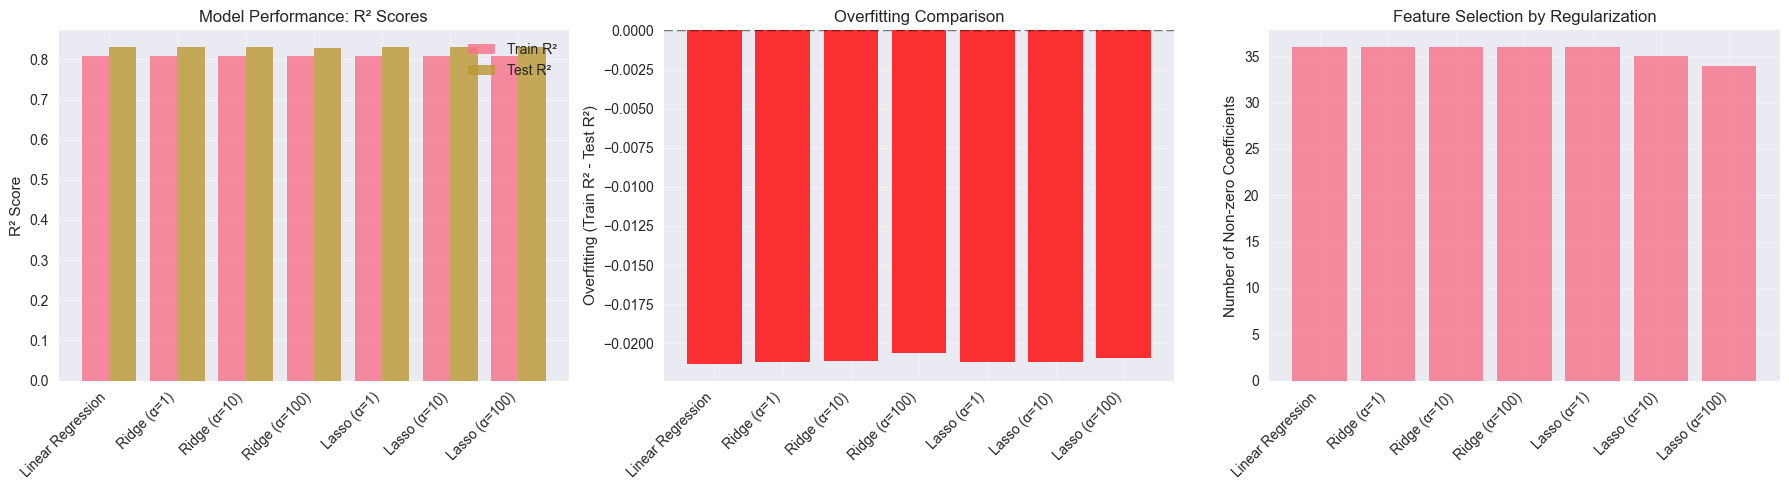

In [18]:
# Visualize model performance
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot R² scores
x_pos = np.arange(len(results_df))
ax1.bar(x_pos - 0.2, results_df['Train R²'], width=0.4, label='Train R²', alpha=0.8)
ax1.bar(x_pos + 0.2, results_df['Test R²'], width=0.4, label='Test R²', alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance: R² Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot overfitting (difference between train and test R²)
ax2.bar(x_pos, results_df['Overfitting'], alpha=0.8, color='red')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('Overfitting (Train R² - Test R²)')
ax2.set_title('Overfitting Comparison')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Plot number of features selected (for regularized models)
regularized_results = results_df[results_df['Non-zero Coefficients'] != 'N/A'].copy()
regularized_results['Non-zero Coefficients'] = pd.to_numeric(regularized_results['Non-zero Coefficients'])

ax3.bar(range(len(regularized_results)), regularized_results['Non-zero Coefficients'], alpha=0.8)
ax3.set_xticks(range(len(regularized_results)))
ax3.set_xticklabels(regularized_results['Model'], rotation=45, ha='right')
ax3.set_ylabel('Number of Non-zero Coefficients')
ax3.set_title('Feature Selection by Regularization')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Comparing Ridge vs Lasso vs Linear Regression 
Let's summarize the key differences and when to use each method:

In [19]:
# Create a comprehensive comparison
comparison_data = {
    'Aspect': [
        'Penalty Type',
        'Mathematical Form', 
        'Coefficient Behavior',
        'Feature Selection',
        'Handles Multicollinearity',
        'Model Interpretability',
        'Best Use Case'
    ],
    'Linear Regression': [
        'None',
        'MSE only',
        'Can be very large',
        'No',
        'No',
        'High (if not overfitting)',
        'Simple datasets, few features'
    ],
    'Ridge (L2)': [
        'Square of coefficients',
        'MSE + α∑βⱼ²',
        'Shrunk toward zero',
        'No (keeps all features)',
        'Yes',
        'Moderate',
        'Many features, multicollinearity'
    ],
    'Lasso (L1)': [
        'Absolute value of coefficients',
        'MSE + α∑|βⱼ|',
        'Can become exactly zero',
        'Yes (automatic)',
        'Partially',
        'High (sparse model)',
        'Feature selection, interpretability'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("📊 Ridge vs Lasso vs Linear Regression Comparison:")
print("=" * 80)
for _, row in comparison_df.iterrows():
    print(f"{row['Aspect']:25} | {row['Linear Regression']:20} | {row['Ridge (L2)']:25} | {row['Lasso (L1)']}")
print("=" * 80)

📊 Ridge vs Lasso vs Linear Regression Comparison:
Penalty Type              | None                 | Square of coefficients    | Absolute value of coefficients
Mathematical Form         | MSE only             | MSE + α∑βⱼ²               | MSE + α∑|βⱼ|
Coefficient Behavior      | Can be very large    | Shrunk toward zero        | Can become exactly zero
Feature Selection         | No                   | No (keeps all features)   | Yes (automatic)
Handles Multicollinearity | No                   | Yes                       | Partially
Model Interpretability    | High (if not overfitting) | Moderate                  | High (sparse model)
Best Use Case             | Simple datasets, few features | Many features, multicollinearity | Feature selection, interpretability


### When to Use Each Method:

#### 🎯 **Use Linear Regression when:**
- You have a small dataset with few features
- Features are not highly correlated
- Model is not overfitting
- You need the simplest possible model

#### 🛡️ **Use Ridge Regression when:**
- You have many features
- Features are highly correlated (multicollinearity)
- You want to keep all features but reduce their impact
- You're dealing with continuous numerical predictions

#### ✂️ **Use Lasso Regression when:**
- You want automatic feature selection
- You need an interpretable model
- You suspect many features are irrelevant
- You want a sparse model (fewer features)

#### 🔄 **Use Elastic Net when:**
- You want benefits of both Ridge and Lasso
- You have groups of correlated features
- You need some feature selection but not too aggressive

## 8. Hyperparameter Tuning 
The most important hyperparameter in Ridge and Lasso regression is **alpha (α)**. Let's learn how to find the optimal value:

In [20]:
# Method 1: Manual grid search with cross-validation
from sklearn.model_selection import cross_val_score

def find_best_alpha(model_class, alphas, X, y, cv=5):
    """
    Find the best alpha using cross-validation
    """
    best_score = -np.inf
    best_alpha = None
    scores = []
    
    for alpha in alphas:
        model = model_class(alpha=alpha)
        score = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()
        scores.append(score)
        
        if score > best_score:
            best_score = score
            best_alpha = alpha
    
    return best_alpha, best_score, scores

# Test range of alpha values
alphas_to_test = np.logspace(-3, 3, 50)  # From 0.001 to 1000

# Find best alpha for Ridge
ridge_best_alpha, ridge_best_score, ridge_scores = find_best_alpha(
    Ridge, alphas_to_test, X_train_final, y_train
)

# Find best alpha for Lasso
lasso_best_alpha, lasso_best_score, lasso_scores = find_best_alpha(
    Lasso, alphas_to_test, X_train_final, y_train
)

print(f"🏆 Best Ridge Alpha: {ridge_best_alpha:.4f} (CV Score: {ridge_best_score:.4f})")
print(f"🏆 Best Lasso Alpha: {lasso_best_alpha:.4f} (CV Score: {lasso_best_score:.4f})")

🏆 Best Ridge Alpha: 184.2070 (CV Score: 0.7704)
🏆 Best Lasso Alpha: 1000.0000 (CV Score: 0.7704)


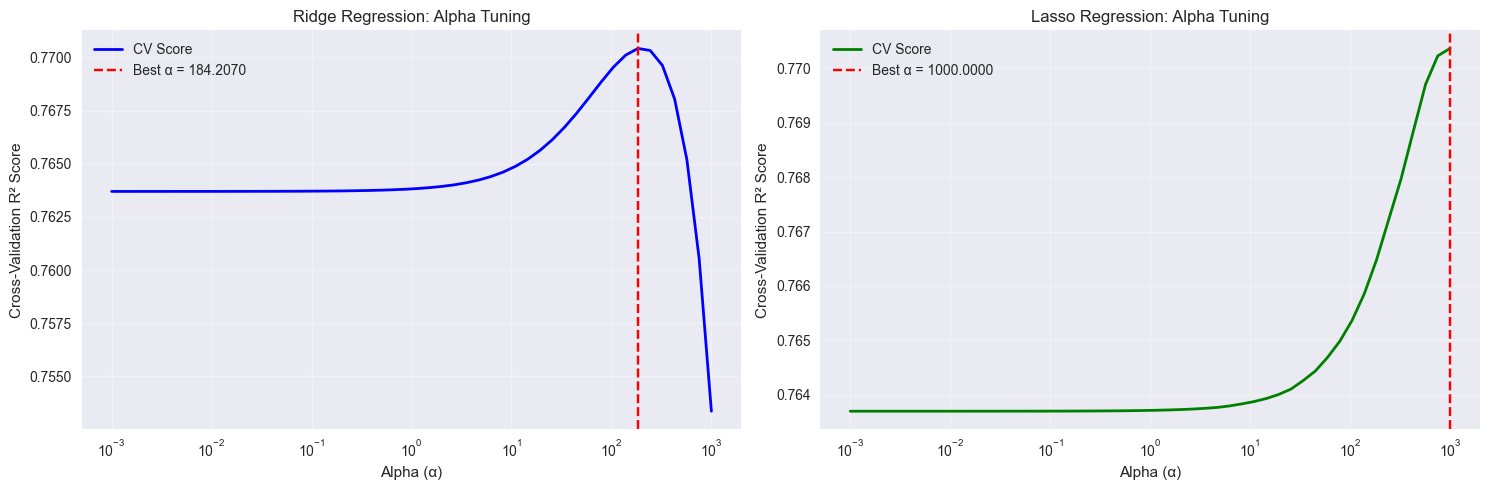

In [21]:
# Visualize the alpha tuning process
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Ridge alpha tuning
ax1.plot(alphas_to_test, ridge_scores, 'b-', linewidth=2, label='CV Score')
ax1.axvline(ridge_best_alpha, color='red', linestyle='--', label=f'Best α = {ridge_best_alpha:.4f}')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (α)')
ax1.set_ylabel('Cross-Validation R² Score')
ax1.set_title('Ridge Regression: Alpha Tuning')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lasso alpha tuning
ax2.plot(alphas_to_test, lasso_scores, 'g-', linewidth=2, label='CV Score')
ax2.axvline(lasso_best_alpha, color='red', linestyle='--', label=f'Best α = {lasso_best_alpha:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (α)')
ax2.set_ylabel('Cross-Validation R² Score')
ax2.set_title('Lasso Regression: Alpha Tuning')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Method 2: Built-in cross-validation (recommended approach)
from sklearn.linear_model import RidgeCV, LassoCV

# Ridge with built-in CV
ridge_cv = RidgeCV(alphas=alphas_to_test, cv=5)
ridge_cv.fit(X_train_final, y_train)

# Lasso with built-in CV
lasso_cv = LassoCV(alphas=alphas_to_test, cv=5, max_iter=1000)
lasso_cv.fit(X_train_final, y_train)

print("✅ Built-in Cross-Validation Results:")
print(f"Ridge optimal α: {ridge_cv.alpha_:.4f}")
print(f"Lasso optimal α: {lasso_cv.alpha_:.4f}")

# Evaluate the tuned models
ridge_tuned_result = evaluate_model(ridge_cv, X_train_final, X_test_final, y_train, y_test, 'Ridge (Tuned)')
lasso_tuned_result = evaluate_model(lasso_cv, X_train_final, X_test_final, y_train, y_test, 'Lasso (Tuned)')

tuned_results = pd.DataFrame([ridge_tuned_result, lasso_tuned_result])
print("\n📈 Tuned Model Performance:")
print(tuned_results.round(4))

✅ Built-in Cross-Validation Results:
Ridge optimal α: 184.2070
Lasso optimal α: 1000.0000

📈 Tuned Model Performance:
           Model  Train R²  Test R²     Train MSE      Test MSE  \
0  Ridge (Tuned)    0.8043   0.8246  1.167021e+09  1.345657e+09   
1  Lasso (Tuned)    0.8053   0.8229  1.161171e+09  1.358136e+09   

   Non-zero Coefficients  Overfitting  
0                     36      -0.0202  
1                     23      -0.0176  

📈 Tuned Model Performance:
           Model  Train R²  Test R²     Train MSE      Test MSE  \
0  Ridge (Tuned)    0.8043   0.8246  1.167021e+09  1.345657e+09   
1  Lasso (Tuned)    0.8053   0.8229  1.161171e+09  1.358136e+09   

   Non-zero Coefficients  Overfitting  
0                     36      -0.0202  
1                     23      -0.0176  


## 9. Feature Selection with Lasso

One of Lasso's most powerful features is automatic feature selection. Let's explore this:

In [23]:
# Use the tuned Lasso model to see which features it selected
feature_names = X_train.columns
lasso_coefs = lasso_cv.coef_

# Create a DataFrame with features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefs,
    'Abs_Coefficient': np.abs(lasso_coefs)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Separate selected and rejected features
selected_features = feature_importance[feature_importance['Abs_Coefficient'] > 1e-5]
rejected_features = feature_importance[feature_importance['Abs_Coefficient'] <= 1e-5]

print(f"🎯 Lasso Feature Selection Results:")
print(f"Selected features: {len(selected_features)} out of {len(feature_names)}")
print(f"Rejected features: {len(rejected_features)} out of {len(feature_names)}")
print(f"Feature reduction: {len(rejected_features)/len(feature_names)*100:.1f}%")

print("\n🏆 Top 10 Most Important Features:")
print(selected_features.head(10)[['Feature', 'Coefficient']].round(4))

🎯 Lasso Feature Selection Results:
Selected features: 23 out of 36
Rejected features: 13 out of 36
Feature reduction: 36.1%

🏆 Top 10 Most Important Features:
         Feature  Coefficient
3    OverallQual   26025.7010
15     GrLivArea   21827.8699
25    GarageCars   10720.7900
5      YearBuilt    7782.6472
0     MSSubClass   -6364.8793
16  BsmtFullBath    4866.3655
6   YearRemodAdd    4552.2381
22  TotRmsAbvGrd    4438.9192
8     BsmtFinSF1    4271.9701
2        LotArea    3737.8331


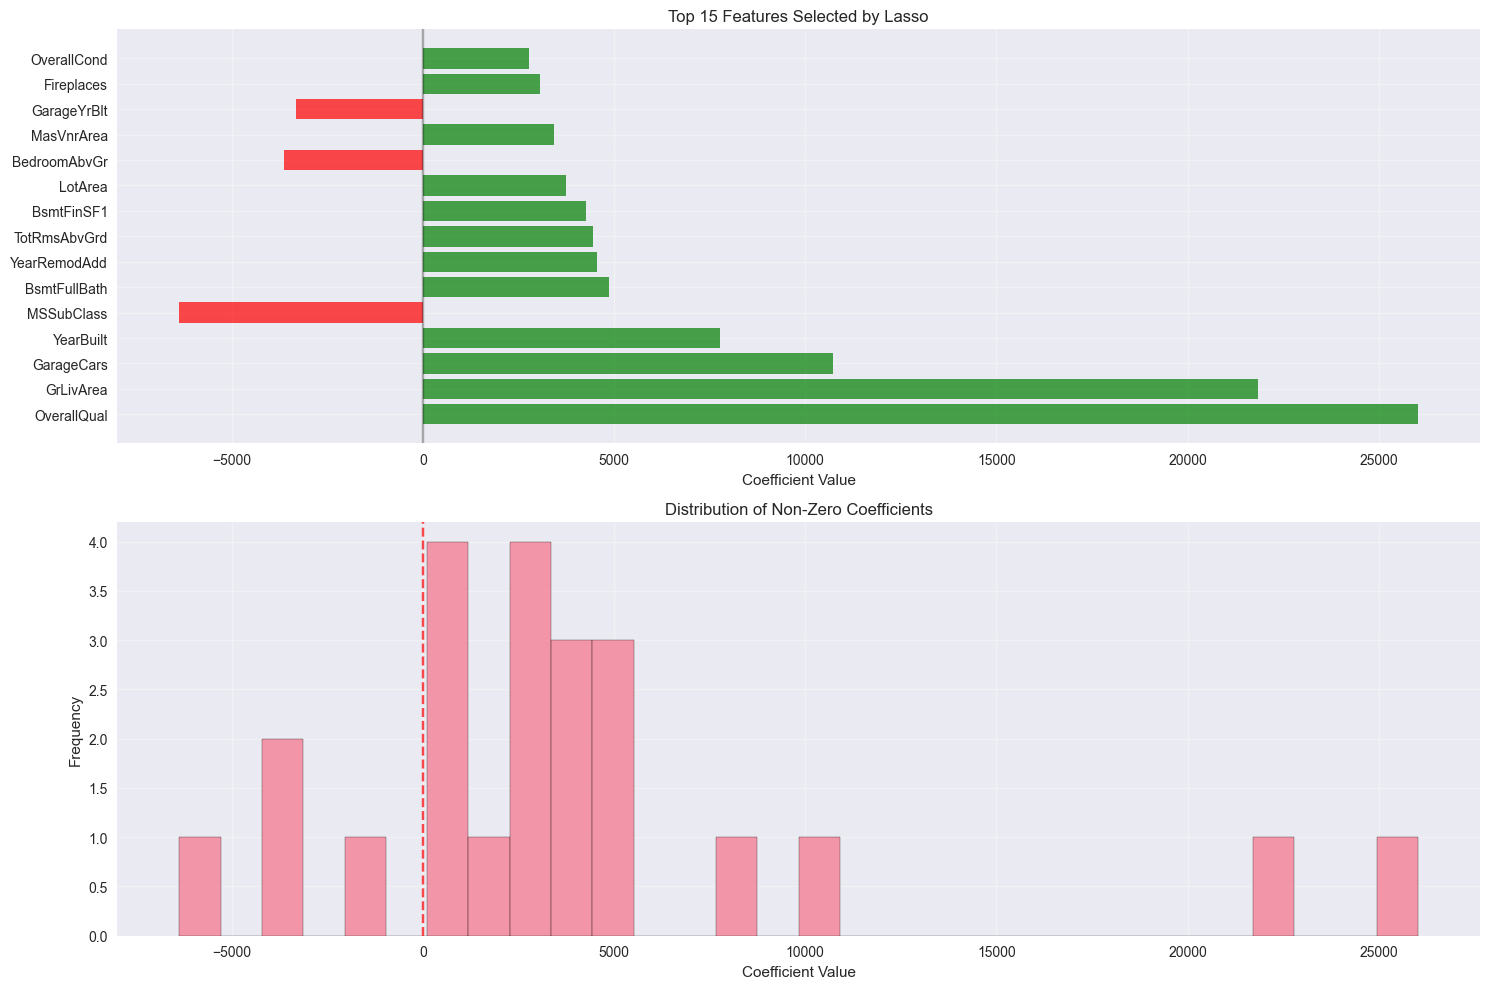

In [24]:
# Visualize feature selection
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot top selected features
top_features = selected_features.head(15)
colors = ['green' if coef > 0 else 'red' for coef in top_features['Coefficient']]

ax1.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'])
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Top 15 Features Selected by Lasso')
ax1.grid(True, alpha=0.3)
ax1.axvline(0, color='black', linestyle='-', alpha=0.3)

# Plot coefficient distribution
ax2.hist(selected_features['Coefficient'], bins=30, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Non-Zero Coefficients')
ax2.grid(True, alpha=0.3)
ax2.axvline(0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [25]:
# Compare model performance with selected features only
selected_feature_names = selected_features['Feature'].tolist()

# Create datasets with only selected features
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Prepare the selected data
X_train_selected_scaled, X_test_selected_scaled, _ = prepare_data(
    X_train_selected, X_test_selected, y_train, y_test
)

# Train models on selected features
lr_selected = LinearRegression()
ridge_selected = Ridge(alpha=ridge_cv.alpha_)
lasso_selected = Lasso(alpha=lasso_cv.alpha_)

# Evaluate models with selected features
selected_results = [
    evaluate_model(lr_selected, X_train_selected_scaled, X_test_selected_scaled, 
                   y_train, y_test, 'Linear (Selected Features)'),
    evaluate_model(ridge_selected, X_train_selected_scaled, X_test_selected_scaled, 
                   y_train, y_test, 'Ridge (Selected Features)'),
    evaluate_model(lasso_selected, X_train_selected_scaled, X_test_selected_scaled, 
                   y_train, y_test, 'Lasso (Selected Features)')
]

selected_results_df = pd.DataFrame(selected_results)
print("🎯 Performance with Lasso-Selected Features:")
print(selected_results_df.round(4))

print(f"\n💡 Using only {len(selected_feature_names)} features instead of {len(feature_names)}!")
print(f"   Feature reduction: {(1 - len(selected_feature_names)/len(feature_names))*100:.1f}%")

🎯 Performance with Lasso-Selected Features:
                        Model  Train R²  Test R²     Train MSE      Test MSE  \
0  Linear (Selected Features)    0.8087   0.8301  1.141241e+09  1.303020e+09   
1   Ridge (Selected Features)    0.8029   0.8221  1.175323e+09  1.364245e+09   
2   Lasso (Selected Features)    0.8053   0.8229  1.161182e+09  1.358181e+09   

   Non-zero Coefficients  Overfitting  
0                     23      -0.0215  
1                     23      -0.0192  
2                     23      -0.0176  

💡 Using only 23 features instead of 36!
   Feature reduction: 36.1%


## 10. Summary and Best Practices
### 🎯 Key Takeaways

1. **Regularization prevents overfitting** by adding penalty terms to the cost function
2. **Ridge (L2)** shrinks coefficients but keeps all features
3. **Lasso (L1)** can set coefficients to zero, performing automatic feature selection
4. **Feature standardization is crucial** before applying regularization
5. **Cross-validation** is the best way to find optimal hyperparameters

### 📋 Best Practices Checklist

✅ **Always standardize features** before regularization  
✅ **Use cross-validation** to find optimal alpha  
✅ **Compare multiple models** to find the best approach  
✅ **Check for overfitting** by comparing train vs test performance  
✅ **Consider the problem context** when choosing between Ridge and Lasso  
✅ **Validate on unseen data** before deploying the model  

### 🛠️ Practical Implementation Steps

1. **Data Preparation**
   - Handle missing values
   - Standardize/normalize features
   - Split into train/validation/test sets

2. **Model Selection**
   - Start with simple linear regression as baseline
   - Try Ridge if you have multicollinearity
   - Try Lasso if you need feature selection
   - Consider Elastic Net for combination benefits

3. **Hyperparameter Tuning**
   - Use `RidgeCV` and `LassoCV` for automatic tuning
   - Test a wide range of alpha values (e.g., 10^-3 to 10^3)
   - Use cross-validation for robust evaluation

4. **Model Evaluation**
   - Compare train vs test performance
   - Look at coefficient values and feature selection
   - Consider interpretability vs performance trade-offs

### 🔮 When to Use Each Method

| Scenario | Recommended Method | Reason |
|----------|-------------------|--------|
| High-dimensional data | Lasso | Automatic feature selection |
| Multicollinearity | Ridge | Handles correlated features well |
| Need interpretability | Lasso | Sparse models easier to interpret |
| All features important | Ridge | Keeps all features with shrinkage |
| Mixed requirements | Elastic Net | Combines Ridge and Lasso benefits |

### 📚 Further Learning

- **Elastic Net**: Combines Ridge and Lasso regularization
- **Cross-validation strategies**: Time series, grouped, stratified
- **Feature engineering**: Creating better features before regularization
- **Advanced regularization**: Sparse Group Lasso, Fused Lasso
- **Regularization in other models**: Logistic regression, neural networks

In [26]:
# Final model comparison summary
print("🏁 FINAL MODEL COMPARISON SUMMARY")
print("=" * 50)

final_comparison = pd.concat([results_df, tuned_results], ignore_index=True)
final_comparison = final_comparison.sort_values('Test R²', ascending=False)

print("Best performing models (by Test R²):")
print(final_comparison[['Model', 'Test R²', 'Overfitting', 'Non-zero Coefficients']].head())

best_model = final_comparison.iloc[0]
print(f"\n🏆 WINNER: {best_model['Model']}")
print(f"   Test R²: {best_model['Test R²']:.4f}")
print(f"   Overfitting: {best_model['Overfitting']:.4f}")
print(f"   Features used: {best_model['Non-zero Coefficients']}")

print("\n🎓 Congratulations! You now understand Ridge and Lasso regression!")
print("💡 Remember: The best model depends on your specific use case and requirements.")

🏁 FINAL MODEL COMPARISON SUMMARY
Best performing models (by Test R²):
               Model   Test R²  Overfitting  Non-zero Coefficients
0  Linear Regression  0.830592    -0.021320                     36
4        Lasso (α=1)  0.830459    -0.021183                     36
5       Lasso (α=10)  0.830452    -0.021177                     35
1        Ridge (α=1)  0.830452    -0.021176                     36
2       Ridge (α=10)  0.830347    -0.021108                     36

🏆 WINNER: Linear Regression
   Test R²: 0.8306
   Overfitting: -0.0213
   Features used: 36

🎓 Congratulations! You now understand Ridge and Lasso regression!
💡 Remember: The best model depends on your specific use case and requirements.
